# Decision theory project

In [60]:
# Imports for the whole labwork

import numpy as np
import pulp
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

##  Tasks 1:  Determination of the value function 

### a. The DM gives his preferences by comparing each pair of alternatives following the Macbeth questioning procedure.

![Image](./matrice_DM.png)

* The DM has given his preferences in this matrix with this scale of preferences : extrem, very strong, strong, moderate, weak, very weak, nul

### b. The analyst checks with the DM possible (inconsistencies) in the preferences especially transitivity

* The software ensures that the judgement is consistent and the transitivity is satisfied (manually verified)

### c. If the binary relation representing the preferences is a weak order, then a value function exists to represent these preferences.


* The binary relation is a weak order so a value function exists.

### d. Assess the value function (solving an optimization problem).

* First, the scale is initialized :

In [61]:
scale = {
    0: "Nulle",
    1: "Very Weak",
    2: "Weak",
    3: "Moderate",
    4: "Strong",
    5: "Very Strong"
}

* With that scale, the matrix of the DM is : 

In [62]:
#order of the social networks
social_networks = ["Sup", "Instagram", "LinkedIn", "X", "Facebook", "Tik Tok", "Inf"]

#-1 is used beacause it is a symetrical matrix
DM_matrix=np.array([[0,3,4,4,4,6,6],
                    [-1,0,3,4,4,5,5],
                    [-1,-1,0,4,4,5,5],
                    [-1,-1,-1,0,3,4,4],
                    [-1,-1,-1,-1,0,4,4],
                    [-1,-1,-1,-1,-1,0,2],
                    [-1,-1,-1,-1,-1,-1,0]])

In [63]:
'''
Define a function which resolves the optimization problem from the DM_matrix to find value the function
'''
def find_value_function(DM_matrix):
    # pulp solver is used
    optimization_problem = pulp.LpProblem("Value_Function", pulp.LpMinimize) #solving an optimization problem
    values = pulp.LpVariable.dicts("Value", range(len(DM_matrix)), lowBound=0)
    optimization_problem += pulp.lpSum([values[i] for i in range(len(DM_matrix))]) 

    for i in range(len(DM_matrix)):
        for j in range(len(DM_matrix[0])):
            if DM_matrix[i][j] != -1: # to only treat the upper diagonal
                optimization_problem += values[i] >= DM_matrix[i][j] + values[j]

    #solve the probleme and recup the value of each class
    optimization_problem.solve()
    value_function = [pulp.value(values[i]) for i in range(len(DM_matrix))]

    return value_function

* Application on our matrix of social networks

In [64]:
value_function = find_value_function(DM_matrix)

print("Our final value function :")
print(social_networks)
print(value_function)


Our final value function :
['Sup', 'Instagram', 'LinkedIn', 'X', 'Facebook', 'Tik Tok', 'Inf']
[19.0, 16.0, 13.0, 9.0, 6.0, 2.0, 0.0]


### e. A ranking can be established regarding the value obtained by each Social network.

Thanks to the value function, the ranking is :
* 1. Instagram
* 2. LinkedIn
* 3. X 
* 4. Facebook
* 5. Tik Tok

## Tasks 2: Supervised classification using expected utility (application to plastics sorting problem)

### a. Identify the utility function.

In [207]:
# Define the utility matrix based on recycling data

utility_matrice = np.array([
    [0.9, 0, 0, 0],  # PP
    [0, 0.9, 0, 0],  # PE
    [0.25, 0.25, 1, 0],  # ABS
    [0.25, 0.25, 0.25, 1]   # HiPS
])

* The DM wants to reduce the errors in HiPS and ABS classification.

### b. Implement the expected utility model.

In [187]:
def EU(predicted, Pabs, Phips, Ppe, Ppp):
    # Depending on the prediction, the probabilities are multiplied
    if predicted == 'PP':
        return (utility_matrice[0][0] * Ppp + utility_matrice[0][1] * Ppe + utility_matrice[0][2] * Pabs + utility_matrice[0][3] * Phips)
    elif predicted == 'PE':
        return (utility_matrice[1][0] * Ppp + utility_matrice[1][1] * Ppe + utility_matrice[1][2] * Pabs + utility_matrice[1][3] * Phips)
    elif predicted == 'ABS':
        return (utility_matrice[2][0] * Ppp + utility_matrice[2][1] * Ppe + utility_matrice[2][2] * Pabs + utility_matrice[2][3] * Phips)
    elif predicted == 'Hips':
        return (utility_matrice[3][0] * Ppp + utility_matrice[3][1] * Ppe + utility_matrice[3][2] * Pabs + utility_matrice[3][3] * Phips)
    else:
        return None

In [188]:
'''
    Choice function returns the class of the plastic using the expected utility
    from probabilities given by a model.
'''
def Choice(Data_to_predict, model):
    a = model.predict_proba(Data_to_predict)  # Use predict_proba to get probabilities from the model

    # multiplication with the EU function 
    act1 = EU('ABS', a[0][0], a[0][1], a[0][2], a[0][3])
    act2 = EU('HiPS', a[0][0], a[0][1], a[0][2], a[0][3])
    act3 = EU('PE', a[0][0], a[0][1], a[0][2], a[0][3])
    act4 = EU('PP', a[0][0], a[0][1], a[0][2], a[0][3])


    #set the probability at 0 if the value is None
    v = [act if act is not None else 0 for act in [act1, act2, act3, act4]]

    #return the class with the highest float
    max_index = v.index(max(v))
    plastic = ['ABS', 'HiPS', 'PE', 'PP']

    return plastic[max_index] 

### c. Test your algorithm on the validation data of plastics (split your data into train and validation).


* Data importation

In [189]:
X = pd.read_csv('./PlasticsTrain.csv',sep=';')

X.drop(['line', 'column', 'object'], axis=1, inplace=True)

# target column
Y = X['class']

# whole dataset
big_df = X

# X columns
X.drop('class',axis = 1, inplace=True)

#replace , to .
X = X[X.columns].apply(lambda x: x.str.replace(',', '.')).astype(float)

#split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [190]:
X.head()

,3687cm-1,3665cm-1,3642cm-1,3620cm-1,3598cm-1,3577cm-1,3555cm-1,3534cm-1,3514cm-1,3493cm-1,...,1952cm-1,1945cm-1,1939cm-1,1933cm-1,1927cm-1,1920cm-1,1914cm-1,1908cm-1,1902cm-1,1896cm-1
0,-1.996200,-1.964828,-1.988133,-1.997992,-1.997096,-1.981858,-1.981858,-1.936146,-1.954073,-1.906568,...,-0.316504,-0.440196,-0.534309,-0.544168,-0.590777,-0.719846,-0.787070,-0.762869,-0.775418,-0.800515
1,-1.931995,-1.932870,-1.952113,-2.006342,-1.984475,-1.968731,-1.966982,-1.936369,-1.910129,-1.862897,...,-0.297249,-0.419702,-0.552651,-0.557899,-0.564896,-0.691723,-0.766069,-0.753824,-0.752949,-0.782688
2,-1.933060,-1.932180,-1.973558,-1.946266,-1.983243,-1.965635,-1.948907,-1.926897,-1.904007,-1.871432,...,-0.247100,-0.328977,-0.444309,-0.450472,-0.481286,-0.615986,-0.659126,-0.630953,-0.650322,-0.660887
3,-1.811951,-1.808491,-1.861257,-1.894992,-1.918348,-1.889802,-1.871637,-1.877692,-1.869907,-1.818871,...,-0.139874,-0.202155,-0.324123,-0.311147,-0.333638,-0.436575,-0.489341,-0.483286,-0.457335,-0.471175
4,-1.911310,-1.917137,-1.959097,-1.969587,-1.960263,-1.962594,-1.948607,-1.936952,-1.913641,-1.849535,...,-0.295847,-0.386761,-0.477674,-0.528959,-0.559263,-0.676984,-0.722441,-0.711951,-0.724772,-0.753911


In [191]:
Y.unique()

array(['ABS', 'HiPS', 'PE', 'PP'], dtype=object)

In [208]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

score = rf_model.score(X_test,y_test)
print('Score without expected utility : ',score)

Score without expected utility :  0.908337396392004


Text(0.5, 1.0, 'Confusion Matrix Random Forest')

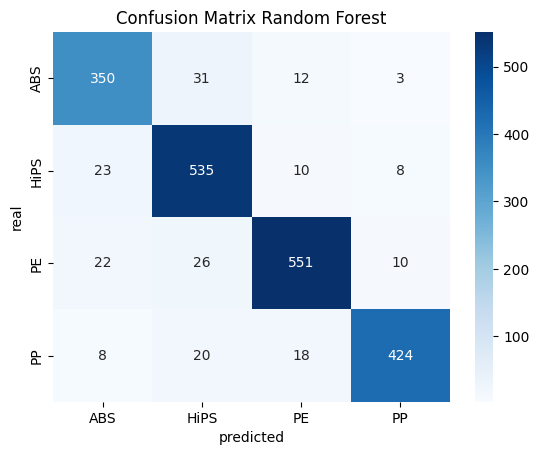

In [193]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['ABS', 'HiPS', 'PE', 'PP'], yticklabels=['ABS', 'HiPS', 'PE', 'PP'])
plt.xlabel("predicted")
plt.ylabel("real")
plt.title("Confusion Matrix Random Forest")

* Use the Expected Utility

In [194]:
def EU_algo(model):
    accuracy_score = 0
    predictions = []  # Liste pour stocker les prédictions
    for i in range(len(X_test)):
        to_test = X_test.iloc[i:i+1]
        predicted = Choice(to_test, model)
        predictions.append(predicted)
        if predicted == y_test.iloc[i]:
            accuracy_score += 1
    return accuracy_score, predictions

In [209]:
accuracy_eu_rf, predictions_rf = EU_algo(rf_model)
print('Score with expected utility with random forest:', accuracy_eu_rf / len(y_test))

Score with expected utility with random forest: 0.6552901023890785


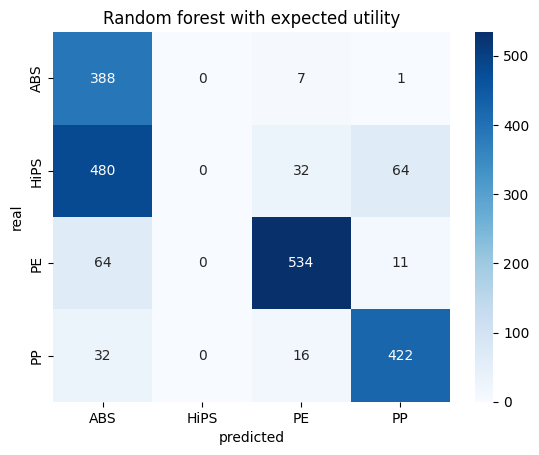

In [210]:
conf_matrix_eu_rf = confusion_matrix(y_test, predictions_rf)

#plot the confusion matrix
sns.heatmap(conf_matrix_eu_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['ABS', 'HiPS', 'PE', 'PP'], yticklabels=['ABS', 'HiPS', 'PE', 'PP'])
plt.xlabel("predicted")
plt.ylabel("real")
plt.title("Random forest with expected utility")
plt.show()

### d. Compare the performances of your algorithm using several classical prediction algorithms on the test plastic data (hidden at the moment).

* Using 2 other models

In [109]:
svm_model = SVC(probability=True)
knn_model = KNeighborsClassifier()

svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

accuracy_eu_svm, pred = EU_algo(svm_model)
accuracy_eu_knn, pred = EU_algo(knn_model)

print('Score with expected utility with SVM : ', accuracy_eu_svm/len(y_test))
print('Score with expected utility with KNN : ', accuracy_eu_knn/len(y_test))

Score with expected utility with SVM :  0.035592393954168695
Score with expected utility with KNN :  0.03900536323744515


* The knn classifier seems to give the best results

## Tasks 3: Supervised classification using evidential KNN (application to plastics sorting problem)

### a. Identify the utility function.

For this question, we keep the same utility function than the Task 2.

In [123]:
import pandas as pd
import numpy as np

utility_matrix = np.array([[1, 0.25, 0.5, 0.75],
                          [0.75, 1, 0.25, 0.5],
                          [0.5, 0.75, 1, 0.25],
                          [0.25, 0.5, 0.75, 1]])

classe = ['ABS', 'HiPS', 'PE', 'PP', 'THETA']

### b. Implement eknn.


* The train and test datasets are the same than Task 2.

Then, the dist_matrix is created : it permits to know all the Euclidean distances between X_i and X_j

In [124]:
# Distances
newDF = pd.concat([X_train, X_test])

# Convertir toutes les colonnes en float
newDF = newDF.replace(',', '.', regex=True)
newDF = newDF.astype(float)

distances = pdist(newDF.values, metric='euclidean')
dist_matrix = squareform(distances)

In [118]:
'''
    fit_gamma permits to get the list of the coefficients [gamma_1, ..., gamma_n]
    coefficients are fitted with the training dataset
'''
def fit_gamma(train_label, dist, classes):
    gamma = []
    nbC = len(classes)
    for i in range(nbC-1):
        C_indices = [t for t in range(len(train_label)) if (train_label[t] == classes[i])]
        C_dist = []
        for ci in range(len(C_indices)):
            for cj in range(ci + 1, len(C_indices)):
                C_dist.append(dist[C_indices[ci]][C_indices[cj]])
        gamma.append(1 / np.mean(C_dist))
    return gamma

In [93]:
# Observing the result
coeff_gamma = fit_gamma(y_train.values, dist_matrix, classe)
print(coeff_gamma)

[0.3822991405629782, 0.3723211618324772, 0.2142873527831586, 0.19209598569774933]


The parameter phi = [phi_1, ..., phi_n] is calculated thanks to the choice : phi_i(d) = alpha exp(-gamma *d ^ 2).

In [94]:
#we fix alpha = 0.95
def phi(gamma, d, alpha=0.95):
    return [alpha*np.exp(-gamma[i]*d**2) for i in range(len(gamma))]

In [95]:
''' 
    voisins is a function which returns the index of the k nearest neighbours from train dataset of a vector X. 
'''

def voisins(index, train_size, y, k):
    index_sort = np.argsort(dist_matrix[index])
    indice_voisins = []

    iteration = 1
    while len(indice_voisins) < k:
        # only index from the training set
        if(index_sort[iteration]<train_size):
            indice_voisins.append(index_sort[iteration])    
        iteration += 1

    distance_voisins = dist_matrix[index, indice_voisins]
    classes = y[indice_voisins]
    
    return indice_voisins, distance_voisins, classes

In [105]:
'''
    m_j compute the piece of evidence and combine the mass functions mj(.|x) using Dempster s rule
    It returns a list associated with each class
'''

def m_j(index, train_size, y, k):
    #collect the information of the neighbours
    indice_voisins, distance_voisins, classes = voisins(index, train_size, y, k)

    # init coeff_ABS 
    coeff_ABS, coeff_HIPS, coeff_PE, coeff_PP = 1, 1, 1, 1

    # compute the numerator of the coefficients of each classes
    for i in range(len(indice_voisins)) :
        current_class = str(classes.iloc[i])
        if current_class == 'ABS':
            coeff_ABS *= (1- phi(coeff_gamma, distance_voisins[i])[0])
        elif current_class == 'HiPS':
            coeff_HIPS *= (1- phi(coeff_gamma, distance_voisins[i])[1])
        elif current_class == 'PE':
            coeff_PE *= (1- phi(coeff_gamma, distance_voisins[i])[2])
        elif current_class == 'PP':
            coeff_PP *= (1- phi(coeff_gamma, distance_voisins[i])[3])
    
    # calcul the fourth m_i(A|X) = [A=theta_i, A!=theta_i]
    m_ABS=[1-coeff_ABS, coeff_ABS]
    m_HIPS=[1-coeff_HIPS, coeff_HIPS]
    m_PE=[1-coeff_PE, coeff_PE]
    m_PP=[1-coeff_PP, coeff_PP]

    m_j =  np.array([m_ABS, m_HIPS, m_PE, m_PP])

    # normalization coeff to compute m 
    product = np.prod(m_j) # empty prediction
    sum = 0
    for i in range(4):
        sum += m_j[i][0]*m_j[(i+1)%4][1]*m_j[(i+2)%4][1]*m_j[(i+3)%4][1]
    n_factor = product + sum

    # calcul m = [m({ABS}), m({HIPS}), m({PE}), m({PP}), m(THETA)]
    m = np.zeros(4)
    for i in range(4):
        m[i] = ( m_j[i][0]*m_j[(i+1)%4][1]*m_j[(i+2)%4][1]*m_j[(i+3)%4][1] ) / n_factor

    # m[4] = 0 # we force the classifier to choose one class
    return m

Then, the variables permit computing eknn

In [108]:
'''
    EKNN uses the pignistic probability and predicts the class.
    It returns the prediction and the real value
'''
def eknn(index, train_size, y, k):

    # Considering k neightbours
    index_voisins, _ , _ = voisins(index, train_size, y, k)
    
    # Compute pignistic probability (BetP)
    betp = np.zeros(4)  
    
    #add each mass associated at each neightbour and divide by the size (k)
    for j in range(len(index_voisins)):
        betp += m_j(index_voisins[j], train_size, y, k)
        
    #betp[4] /= 4 # |THETA|=4
    
    indice_classe_pred = np.argsort(betp)[0]
    
    classe_pred = classe[indice_classe_pred]
    
    return classe_pred, y[index]

In [109]:
pred, real = eknn(10029, len(X_train), y, 4)

In [110]:
pred, real

('PP', 'PP')

In [114]:
#Try the EKNN with 10 neightbours

true = 0
false = 0
k = 10
for i in range(len(X_train), len(big_df)):
    pred, expected = eknn(i, len(X_train), Y, k)
    if pred == expected :
        true += 1
    else :
        false += 1

In [115]:
print(true/ (len(big_df)-len(X_train)))

0.9205265724037055


The accuracy is around 93% with 10 neighbours

In [125]:
X = [1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50]
accuracy= np.zeros(len(X))

for k in range(len(X)):
    true = 0
    false = 0
    k = X[k]
    for i in range(len(X_train), len(big_df)):
        pred, expected = eknn(i, len(X_train), y, k)
        if pred == expected :
            true += 1
        else :
            false += 1
    accuracy[k] = true / (len(big_df) - len(X_train))

IndexError: index 15 is out of bounds for axis 0 with size 11

Observing the evolution of accuracy with differents value of k

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Evolution of k")
plt.ylabel("Accuracy")
plt.title("Evolution of accuracy according to k")
plt.plot()

### c. Implement the expected utility model with eknn.

In [120]:
'''
    EKNN algorithm with expected utility.
'''

def EU_eknn(index, train_size, y, k):

    index_voisins, _, _ = voisins(index, train_size, y, k)
    
    betp = np.zeros(4)
    
    for j in range(len(index_voisins)):
        betp += m_j(index_voisins[j], train_size, y, k)
    
    # Compute expected utility
    expected_utility = np.dot(betp, np.dot(utility_matrix, betp))
    
    indice_classe_pred = np.argmax(betp)
    classe_pred = classe[indice_classe_pred]
    
    return classe_pred, y[index], expected_utility

In [122]:
true = 0
false = 0
total_utility = 0
k = 10
for i in range(len(X_train), len(big_df)):
    pred, expected, utility = EU_eknn(i, len(X_train), Y, k)
    total_utility += utility
    if pred == expected:
        true += 1
    else:
        false += 1

accuracy = true / (true + false)
average_utility = total_utility / (true + false)

print('Accuracy:', accuracy)

Accuracy: 0.0
Average Expected Utility: 76.60754829168407
